<a href="https://colab.research.google.com/github/ayush-2405/Sudoku_Solver/blob/main/SudokuCnn_Model_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import copy
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive')
import os
import albumentations as A

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [114]:
labels = os.listdir('/content/gdrive/MyDrive/Sudoku/assets')
print(labels)

['0', '5', '4', '8', '7', '6', '3', '1', '2', '9']


In [115]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [116]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **GETTING DATA**

In [117]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [118]:
X = np.array(X)
y = np.array(y,dtype = np.int64)

X = ((X-np.mean(X))/(np.std(X)))
X = X.reshape(X.shape[0],1,28,28)

In [119]:
X = X.astype('float')
y = np.int_(y)

In [120]:
X = torch.tensor(X,device = device,dtype = torch.float)
y = torch.tensor(y,device = device)
y = y.type(torch.LongTensor)

In [121]:
import PIL
X_2 = []
y_2 = []
for label in labels:
  images_path = os.path.join('/content/gdrive/MyDrive/Sudoku/assets', label)
  images = os.listdir(images_path)
  for img in images:
        image = PIL.Image.open(os.path.join(images_path, img))
        image = image.convert("L")
        X_2.append(np.array(image).reshape(784))
        y_2.append(label)

X_2 = np.array(X_2)
y_2 = np.array(y_2,dtype = np.int64)

X_2 = ((X_2-np.mean(X_2))/(np.std(X_2)))
X_2 = X_2.reshape(X_2.shape[0],1,28,28)
print(X_2[0],y_2[0])

[[[-0.34725139 -0.36163253 -0.34725139 -0.36163253 -0.34725139
   -0.33287024 -0.36163253 -0.36163253 -0.36163253 -0.36163253
   -0.36163253 -0.36163253 -0.36163253 -0.36163253 -0.36163253
   -0.36163253 -0.34725139 -0.36163253 -0.36163253 -0.34725139
   -0.33287024 -0.36163253 -0.36163253 -0.36163253 -0.36163253
   -0.36163253 -0.34725139 -0.34725139]
  [-0.36163253 -0.30410794 -0.36163253 -0.33287024 -0.36163253
   -0.36163253 -0.31848909 -0.36163253 -0.36163253 -0.36163253
   -0.36163253 -0.36163253 -0.36163253 -0.36163253 -0.36163253
   -0.36163253 -0.36163253 -0.27534564 -0.36163253 -0.36163253
   -0.33287024 -0.34725139 -0.36163253 -0.34725139 -0.36163253
   -0.34725139 -0.36163253 -0.36163253]
  [-0.36163253 -0.36163253  3.29117916  3.30556031  3.30556031
    3.30556031  3.30556031  3.29117916  3.30556031  3.30556031
    3.30556031  3.30556031  3.30556031  3.30556031  3.30556031
    3.30556031  3.29117916  3.29117916  3.30556031  3.30556031
    3.30556031  3.24803572  3.30556031

In [122]:
X_2 = torch.tensor(X_2)
y_2 = torch.tensor(y_2)
y_2 = y_2.type(torch.LongTensor)

In [123]:
from sklearn.model_selection import train_test_split

X_train1,X_val1,y_train1,y_val1 = train_test_split(X_2,y_2, test_size=0.2, random_state=42)
print(X_train1.shape,X_val1.shape,y_train1.shape,y_val1.shape)
X_train1=X_train1.to(device)
X_val1=X_val1.to(device)
y_train1=y_train1.to(device)
y_val1=y_val1.to(device)

torch.Size([5047, 1, 28, 28]) torch.Size([1262, 1, 28, 28]) torch.Size([5047]) torch.Size([1262])


In [124]:
X_train2,X_val2,y_train2,y_val2 = train_test_split(X,y, test_size=0.2, random_state=42)
X_train2 = X_train2.to(device)
X_val2 = X_val2.to(device)
y_train2 = y_train2.to(device)
y_val2 = y_val2.to(device)
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape

(torch.Size([56000, 1, 28, 28]),
 torch.Size([56000]),
 torch.Size([14000, 1, 28, 28]),
 torch.Size([14000]))

In [125]:
X_train = torch.cat((X_train2,X_train1))
X_val = torch.cat((X_val2,X_val1))
y_train = torch.cat((y_train2,y_train1))
y_val = torch.cat((y_val2,y_val1))

print(X_train.shape,y_train.shape,X_val.shape,y_val.shape)


torch.Size([61047, 1, 28, 28]) torch.Size([61047]) torch.Size([15262, 1, 28, 28]) torch.Size([15262])


In [126]:
train_dataset = TensorDataset(X_train,y_train)
val_dataset = TensorDataset(X_val,y_val)

In [127]:
num_batch = 128

train_dataloader = DataLoader(dataset=train_dataset,batch_size = num_batch)
val_dataloader = DataLoader(dataset=val_dataset,batch_size = num_batch)

# **BUILDING MODEL**

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time


class sudokuCnn(nn.Module):
  def __init__(self,output_classes,in_channels = 1):
    super(sudokuCnn,self).__init__()
    self.conv1 = nn.Conv2d(1,32,kernel_size = 5,stride = 1,padding = 1)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32,32,kernel_size = 3, stride = 1,padding = 1)
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(1152,128)
    self.dropout1 = nn.Dropout(p=0.2)
    self.fc2 = nn.Linear(128,64)
    self.output = nn.Linear(64, output_classes)

  def forward(self,x):
    x=x.float()
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)
    x = x.reshape(x.shape[0],-1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout1(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.output(x)
    x = F.softmax(x)

    return x



# **VALIDATING MODEL**

In [129]:
def check_accuracy(model,dataloader):
  num_correct = 0
  num_samples = 0
  model.eval()
  model = model.to(device)

  with torch.no_grad():
    for DATA  in dataloader:
      data = DATA[0].float()
      data = data.to(device)
      classes = DATA[1].float()
      classes = classes.to(device)
      scores = model(data)
      predictions = scores.argmax(1)
      num_correct += sum((predictions == classes))
      num_samples += predictions.size(0)

    return float(num_correct)/float(num_samples)

# **TRAINING FUNCTION**

In [130]:
def train (model,loss_function,optimizer,train_dl,val_dl,epochs):
  if torch.cuda.is_available(): torch.cuda.empty_cache()
  model = model.to(device = device)
  history = {"train_accuracies": [], "val_accuracies": [], "loss":[]}

  for epoch in range (epochs):

    model.train()
    train_loss = 0
    start = time.time()

    for batch_no,DATA in enumerate(train_dl,0):
      data,classes = DATA
      optimizer.zero_grad()
      data = data.to(torch.float32)
      data = data.to(device).float()
      classes = classes.to(device)
      outputs = model(data)
      loss = loss_function(outputs,classes)
      loss.backward()
      optimizer.step()


      running_loss = loss.item()

    #getting the stats
    history['train_accuracies'].append(check_accuracy(model,train_dl))
    history['val_accuracies'].append(check_accuracy(model,val_dl))
    history['loss'].append(running_loss/(len(train_dl)))

    end = time.time()
    total_time = end-start

    #printing the stats
    print('Epoch ({}/{}),Training loss : {:.8f}, Time: {:.2f}, train_accuracy:{:.4f}, val_accuracy:{:.4f}'.format(
          epoch+1, epochs, history["loss"][-1], total_time, history["train_accuracies"][-1], history["val_accuracies"][-1]))

  return model, history

In [131]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

device(type='cuda', index=0)

# **TRAINING THE MODEL**

In [132]:
epochs = 10
learning_rate = 1e-3

In [112]:
model  = sudokuCnn(output_classes=10)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [133]:
start = time.time()
model,history = train(model = model,
                      loss_function=loss_fn,
                      optimizer = optimizer,
                      train_dl = train_dataloader,
                      val_dl = val_dataloader,
                      epochs = epochs)
end = time.time()
elapsed = end-start
print("Total time :", elapsed)

<ipython-input-110-b2e4e3b93e43>:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch (1/10),Training loss : 0.00367702, Time: 3.52, train_accuracy:0.8835, val_accuracy:0.8799
Epoch (2/10),Training loss : 0.00348519, Time: 4.47, train_accuracy:0.8988, val_accuracy:0.8958
Epoch (3/10),Training loss : 0.00325825, Time: 3.68, train_accuracy:0.9327, val_accuracy:0.9296
Epoch (4/10),Training loss : 0.00323324, Time: 3.49, train_accuracy:0.9596, val_accuracy:0.9543
Epoch (5/10),Training loss : 0.00318869, Time: 3.46, train_accuracy:0.9603, val_accuracy:0.9541
Epoch (6/10),Training loss : 0.00312545, Time: 4.45, train_accuracy:0.9771, val_accuracy:0.9720
Epoch (7/10),Training loss : 0.00310886, Time: 3.50, train_accuracy:0.9824, val_accuracy:0.9761
Epoch (8/10),Training loss : 0.00313558, Time: 3.45, train_accuracy:0.9836, val_accuracy:0.9753
Epoch (9/10),Training loss : 0.00315765, Time: 3.94, train_accuracy:0.9830, val_accuracy:0.9773
Epoch (10/10),Training loss : 0.00310654, Time: 4.14, train_accuracy:0.9831, val_accuracy:0.9762
Total time : 38.113142251968384


In [134]:
def plot_analysis(history,epochs):
  epoch_no = [(i+1) for i in range(epochs)]

  plt.plot(epoch_no,history["train_accuracies"], label = 'Train Accuracies')
  plt.plot(epoch_no,history["val_accuracies"], label = 'Validation Accuracies')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracies")
  plt.title('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epoch_no,history["loss"])
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title('Loss')
  plt.show()


# **SAVING THE BEST MODEL**

In [63]:
torch.save(model.state_dict(), 'modelweights.pth')

# **PLOT ANALYSIS**

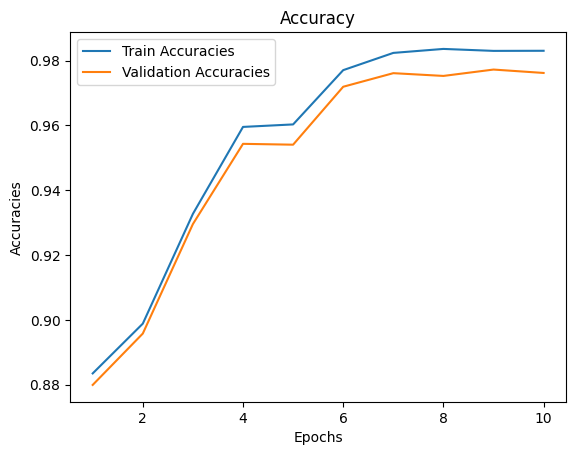

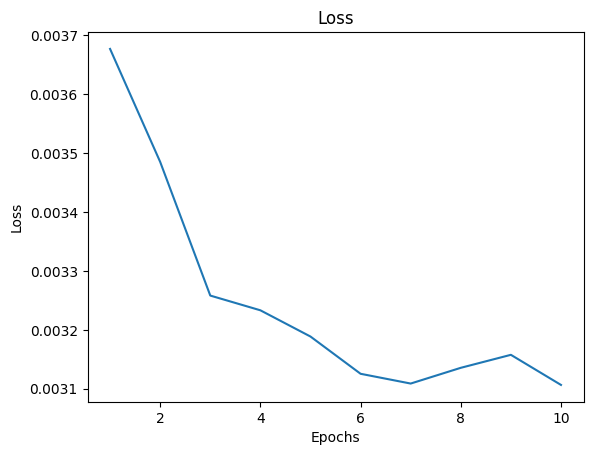

In [135]:
plot_analysis(history,epochs)

# **PREDICTION**

In [136]:
def predict(model,x):
    device = torch.device("cuda")
    model.eval()
    model = model.to(device = device)
    with torch.no_grad():
      x.to(device)
      scores = model(x)
      prediction = scores.argmax(1)

    return prediction

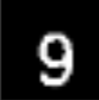

In [137]:
img=cv2.imread('9.png')
if img is None:
    raise FileNotFoundError('The image file could not be read. Please check the file path.')

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (28, 28))

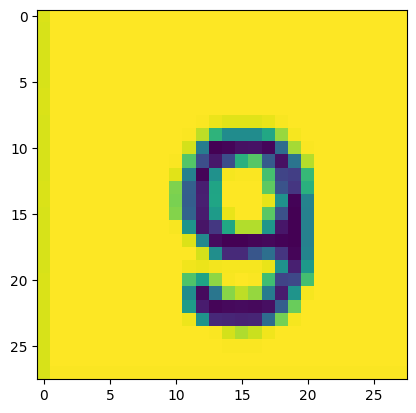

In [138]:
plt.imshow(x)

# **PREDICTION**

In [139]:
digit = torch.tensor(img)
digit = digit.reshape((1,1,28,28)).float()
model.eval()
digit = digit.to(device)

In [140]:
digit_read = predict(model,digit)
print(digit_read)

tensor([9], device='cuda:0')


<ipython-input-110-b2e4e3b93e43>:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
